<h1 style= 'color : red'>Natural Language Processing</h1>

In [1]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub

## Getting data
Kaggle introduction to NLP dataset (test samples of Tweets labeled as disaster or not disaster)
### Visualizing the text Data

In [3]:
# IF the text file is large then you can use tf.keras.preprocessing.text_dataset_from_directory(use docs)
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df['text'][1]

'Forest fire near La Ronge Sask. Canada'

In [5]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
train_df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [7]:
# How many total samples
len(train_df),len(test_df)

(7613, 3263)

In [8]:
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [9]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
Aftershock was the most terrifying best roller coaster I've ever been on. *DISCLAIMER* I've been on very few.

---

Target: 1 (real disaster)
Text:
Severe thunderstorm warning remains for #Cochrane. @cityofcalgary has enacted municipal emergency plan after today's storm. #abstorm

---

Target: 0 (not real disaster)
Text:
Just had a heart attack because I thought my goat was dead. ???? don't worry Rocket is okay. ??

---

Target: 1 (real disaster)
Text:
FreeBesieged: .MartinMJ22 YouGov Which '#Tory landslide' ... you can't POSSIBLY mean the wafer-thin majority of #GÛ_ http://t.co/2q3fuEReY5

---

Target: 1 (real disaster)
Text:
Video:  Fire burns two apartment buildings and blows up car in Manchester http://t.co/5BGcw3EzB5

---



### Split training data into training and validation sets

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [12]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into number

### Tokenisation(using Text vectorization layer)

In [14]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [15]:
# train_sentences is an array where each element is represent a sentence
# average len of word in each tweet 
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [16]:
# setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [17]:
# Fit the text vectorizer to the training text
# Tokens for the word present in the corpus of the train_Sentences are created  
text_vectorizer.adapt(train_sentences)

In [18]:
# Creating a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [19]:
# Choose a random sentence from the train dataset and vectorize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
IÛªve just signed up for the Detonate Nottingham Autumn Launch Party. Register here: http://t.co/Km8uCIHrRN      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[3731,   29, 1592,   27,   10,    2,  437,    1, 6154, 3688, 1116,
        2322,  140,    1,    0]], dtype=int64)>

In [20]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating Embedding using an Embedding layer out of the tokens created
**tf.keras.layers.Embedding**
* `input_dim` = the size of the vocabulary
* `output_dim` = the size of the output embedding vector, for example a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences passed to embedding layer

In [21]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

In [22]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
I understand why broke ppl be mad or always hav an attitude now this sht ain't no fun i won't be desolate for long      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03030514, -0.02349203,  0.04074421, ..., -0.01770914,
         -0.01424841, -0.01112295],
        [ 0.00270101,  0.03332465,  0.00822514, ...,  0.04826507,
         -0.01720385,  0.03803361],
        [ 0.03906803,  0.01494766, -0.01827056, ..., -0.03245278,
         -0.04688815, -0.00693762],
        ...,
        [ 0.04971829, -0.04373407, -0.01165318, ..., -0.01859822,
          0.00922766,  0.02713355],
        [ 0.03770058, -0.03205447, -0.02423008, ..., -0.04594673,
          0.00588086, -0.04889062],
        [-0.02591035,  0.0455557 ,  0.02248385, ...,  0.03743884,
          0.02644101, -0.02009802]]], dtype=float32)>

In [23]:
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.03030514, -0.02349203,  0.04074421, -0.0387397 ,  0.02163589,
         0.00435159, -0.0317978 , -0.02260407, -0.01573086, -0.03794418,
        -0.01773132, -0.02912896,  0.01200478, -0.01883222, -0.02650359,
         0.01529619,  0.03640052,  0.01246773,  0.01328652, -0.00925559,
        -0.00642911, -0.03960434,  0.00622398,  0.03426546, -0.0377897 ,
        -0.02948803,  0.04613603, -0.01668205,  0.02009315, -0.03860249,
        -0.02193052, -0.02619132,  0.04763068, -0.04460371, -0.0361738 ,
        -0.00146567, -0.04803443, -0.04567415, -0.04388979,  0.00721496,
         0.01418063,  0.03994531,  0.02591768, -0.03346946, -0.01767104,
         0.02651013, -0.01122495, -0.03159456, -0.03346961,  0.04951687,
         0.03290265, -0.02087771,  0.00758073,  0.0308288 ,  0.00026704,
         0.00410403,  0.00205987,  0.00139641,  0.01778951,  0.0420354 ,
         0.01912608,  0.01651203, -0.03663079,  0.04650583,  0.04555677,
  

<h1 style= 'color : red'> Model 0 Getting baseline</h1>
 

**Model used: Naive Bayes----&----TF-IDF used to convert words to text**

Procedure we follow
* Create a model
* Build a model
* Fit a model
* Evaluate a model

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences,val_labels)

In [26]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [27]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

### Create a function to evaluate model's performance using
* Accuracy
* Precision
* Recall
* F1-score

In [28]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [29]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results


{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

<h1 style= 'color : red'> Model 1: Simple dense Model (FFNN)</h1>

In [30]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [31]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [32]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [33]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [34]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20240827-095419
Epoch 1/5
215/215 [==============================] - 5s 15ms/step - loss: 0.6115 - accuracy: 0.6929 - val_loss: 0.5368 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4423 - accuracy: 0.8181 - val_loss: 0.4689 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3473 - accuracy: 0.8613 - val_loss: 0.4586 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2858 - accuracy: 0.8924 - val_loss: 0.4636 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2389 - accuracy: 0.9120 - val_loss: 0.4758 - val_accuracy: 0.7861


In [35]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4758 - accuracy: 0.7861


[0.4758185148239136, 0.7860892415046692]

In [36]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-1.1271731e-02, -1.7800119e-02, -1.2910995e-02, ...,
         -2.9190624e-02,  5.5569997e-03,  9.2277158e-05],
        [ 5.8396733e-03, -4.2577546e-02,  5.0597028e-03, ...,
          5.9467312e-03,  2.2956638e-03,  5.0888669e-02],
        [ 2.5563380e-02, -7.7281441e-03, -2.5907075e-02, ...,
         -6.0120646e-02,  5.2640643e-02,  1.3094749e-03],
        ...,
        [-5.6607015e-03, -1.1870671e-02, -3.5583712e-02, ...,
         -4.5079600e-02, -1.0012519e-02,  3.1794775e-02],
        [ 8.5820273e-02, -3.4411609e-02,  4.5422028e-04, ...,
         -5.5849701e-02,  1.9258030e-02,  3.5985213e-02],
        [ 4.3221660e-02, -4.0971242e-02,  9.5894836e-02, ...,
         -6.4260900e-02,  8.2379624e-02,  1.0724136e-01]], dtype=float32)>]

In [37]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 3ms/step


(762, 1)

In [38]:
model_1_pred_probs[0]

array([0.40840182], dtype=float32)

In [39]:
# Convert model's prediction probabilities into 0/1 labels
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

In [40]:
model_1_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [41]:
# Calculate our model results
model_1_results = calculate_results(y_true=val_labels,
                                   y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

In [42]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [43]:
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Visualizing the embeddings that the model has learned

In [44]:
# Get the vocabulary from the vectorization layers
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [45]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [46]:
# Get the weight matrix of embedding layer 
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 128)


In [47]:
embed_weights[0].shape

(128,)

https://projector.tensorflow.org/
we can use this to visualize the word embeddings that we have created
and use the text docs of tensorflow embeddings
https://www.tensorflow.org/text/guide/word_embeddings

In [48]:
import io

In [49]:
# Create embedding files (from tensporflow word embedding docs)
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()


<h1 style= 'color : blue'>Recurrent Neural Networks(RNN's)</h1>

**Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)**

<h2 style= 'color : brown'>LSTM</h2>

In [50]:
# Create an LSTM model
from tensorflow.keras import layers
input = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
# print(x.shape)
x = embedding(x)
# print(x.shape)
# Having 2 LSTM layers
# x = layers.LSTM(units=64, return_sequences=True)(x)
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation = 'relu')(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_2 = tf.keras.Model(inputs,outputs, name= 'model_2_LSTM')

In [51]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [52]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

In [53]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences,val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   'model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20240827-095439
Epoch 1/5
215/215 [==============================] - 11s 28ms/step - loss: 0.2281 - accuracy: 0.9136 - val_loss: 0.5399 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 4s 21ms/step - loss: 0.1634 - accuracy: 0.9412 - val_loss: 0.5953 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.1289 - accuracy: 0.9511 - val_loss: 0.7185 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.1078 - accuracy: 0.9596 - val_loss: 0.8118 - val_accuracy: 0.7913
Epoch 5/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0846 - accuracy: 0.9654 - val_loss: 0.9342 - val_accuracy: 0.7822


In [54]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 7ms/step


array([[7.9561602e-03],
       [7.0063782e-01],
       [9.9945945e-01],
       [3.6543269e-02],
       [2.3346418e-04],
       [9.9779773e-01],
       [8.1187719e-01],
       [9.9968463e-01],
       [9.9949515e-01],
       [5.5802971e-01]], dtype=float32)

In [55]:
# Convert model 2 pred prods to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [56]:
# Calculating model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                   y_pred=model_2_preds)
model_2_results

{'accuracy': 78.21522309711287,
 'precision': 0.7840694582051416,
 'recall': 0.7821522309711286,
 'f1': 0.7801766074787211}

<h2 style= 'color : brown'>Gated Recurrent Unit(GRU)</h2>

In [57]:
# Build aan RNN using the GRU cell
from tensorflow.keras import layers, models
import tensorflow as tf

# Assume text_vectorizer and embedding are defined elsewhere
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x) # Recurrent layers stack on top of eachother --> return_sequence=True 
# x = layers.LSTM(64, return_sequences=True)(x)
# x = layers.GRU(64)(x)
# x = layers.Dense(64, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_3 = models.Model(inputs, outputs, name='model_3_GRU')


In [58]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 

In [59]:
# Compile the model
model_3.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

In [60]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences,val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   'model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20240827-095511
Epoch 1/5
215/215 [==============================] - 12s 28ms/step - loss: 0.1747 - accuracy: 0.9461 - val_loss: 0.6382 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 5s 22ms/step - loss: 0.1046 - accuracy: 0.9625 - val_loss: 0.7553 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0847 - accuracy: 0.9686 - val_loss: 0.9511 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0767 - accuracy: 0.9705 - val_loss: 0.9754 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0627 - accuracy: 0.9739 - val_loss: 0.9948 - val_accuracy: 0.7598


In [61]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[0.1457882 ],
       [0.8357145 ],
       [0.99993575],
       [0.08878954],
       [0.0014206 ],
       [0.9998032 ],
       [0.98584634],
       [0.9999845 ],
       [0.9999839 ],
       [0.63356286]], dtype=float32)

In [62]:
# Convering the prediction probabilities into labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [63]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                   y_pred=model_3_preds)
model_3_results

{'accuracy': 75.98425196850394,
 'precision': 0.7594780880165999,
 'recall': 0.7598425196850394,
 'f1': 0.7590768821741806}

<h2 style= 'color : brown'>Bidirectional LSTM</h2>

In [64]:
# Building a biirectional RNN 
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1,activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_bidirectional')

In [65]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               74496     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1354625 (5.17 MB)
Trainable par

In [66]:
# compile model
model_4.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [67]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20240827-095545
Epoch 1/5
215/215 [==============================] - 17s 34ms/step - loss: 0.1244 - accuracy: 0.9615 - val_loss: 0.7728 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0664 - accuracy: 0.9749 - val_loss: 0.9164 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0551 - accuracy: 0.9775 - val_loss: 1.1132 - val_accuracy: 0.7533
Epoch 4/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0495 - accuracy: 0.9781 - val_loss: 1.2273 - val_accuracy: 0.7546
Epoch 5/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0437 - accuracy: 0.9806 - val_loss: 1.3027 - val_accuracy: 0.7559


In [68]:
# Make predictions with our bidirectional models
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 2s 8ms/step


array([[8.8538503e-04],
       [6.0125065e-01],
       [9.9988109e-01],
       [1.1948193e-01],
       [3.7261892e-05],
       [9.9950713e-01],
       [9.7514731e-01],
       [9.9997252e-01],
       [9.9990433e-01],
       [9.9452180e-01]], dtype=float32)

In [69]:
# Convert pred probs to pred labels 
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [70]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                   y_pred=model_4_preds)
model_4_results

{'accuracy': 75.59055118110236,
 'precision': 0.7558252056840676,
 'recall': 0.7559055118110236,
 'f1': 0.7546752743603138}

<h2 style= 'color : green'>Convolution Neural Networks for Text</h2>
we hv used CNN's for image ie. conv2D we can use conv1D for sequential data.

`Inputs(text) -> Tokenization -> Embedding -> layers(typically Conv1D + pooling) -> output layer`

In [71]:
# Test out our embedding layer, Conv1d layer and max Pooling
embedding_test = embedding(text_vectorizer(['this is a test sentence']))
conv_1d = layers.Conv1D(filters=32,
                       kernel_size=5,
                       activation='relu',
                       padding='valid')
conv_1d_output = conv_1d(embedding_test) # passing test embedding through conv1D layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the feature vectors with the highest value

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [72]:
# Create 1-Dimentional convolutional layer to model sequences
inputs = layers.Input(shape=(1,), dtype= tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation='relu', padding='valid')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_conv1D')

# Compile Conv1D
model_5.compile(loss='binary_crossentropy',
               optimizer= tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# summary of our model
model_5.summary()

Model: "model_5_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [73]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   'Conv1D')])

Saving TensorBoard log files to: model_logs/Conv1D/20240827-095625
Epoch 1/5
215/215 [==============================] - 5s 16ms/step - loss: 0.1154 - accuracy: 0.9616 - val_loss: 0.8991 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0706 - accuracy: 0.9736 - val_loss: 1.0624 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0599 - accuracy: 0.9758 - val_loss: 1.1128 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0538 - accuracy: 0.9783 - val_loss: 1.2099 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0493 - accuracy: 0.9787 - val_loss: 1.2411 - val_accuracy: 0.7612


In [74]:
# Make some predictions 
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 5ms/step


array([[1.2897032e-01],
       [6.2086737e-01],
       [9.9993736e-01],
       [7.6369330e-02],
       [4.0280361e-07],
       [9.8650599e-01],
       [9.7568226e-01],
       [9.9998713e-01],
       [9.9999988e-01],
       [8.4160060e-01]], dtype=float32)

In [75]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [76]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                   y_pred=model_5_preds)
model_5_results

{'accuracy': 76.11548556430446,
 'precision': 0.7617086366916097,
 'recall': 0.7611548556430446,
 'f1': 0.7594983627881855}

<h2 style= 'color : green'>Tensorflow Hub Pretrained Sentence Encoder</h2>

**The model we gonna use is Universal sentence Encoder (USE)**
link: https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2?tfhub-redirect=true

In [77]:
sentence_encoder_layer =  hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                                                         input_shape=[],
                                                                         dtype=tf.string,
                                                                         trainable=False)


In [78]:
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  # layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])

model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [79]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentence_encoder') ])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20240827-100210
Epoch 1/5
215/215 [==============================] - 10s 20ms/step - loss: 0.6475 - accuracy: 0.7357 - val_loss: 0.6116 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.5809 - accuracy: 0.7888 - val_loss: 0.5624 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.5382 - accuracy: 0.7951 - val_loss: 0.5309 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.5096 - accuracy: 0.7996 - val_loss: 0.5100 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4896 - accuracy: 0.7997 - val_loss: 0.4956 - val_accuracy: 0.7874


In [80]:
# Make predictions with the model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 11ms/step


array([[0.34553993],
       [0.67360264],
       [0.85108185],
       [0.35693794],
       [0.6500365 ],
       [0.7323644 ],
       [0.8344066 ],
       [0.83695966],
       [0.7537254 ],
       [0.18524794]], dtype=float32)

In [81]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [82]:
# Calculate model 6 performances metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 78.74015748031496,
 'precision': 0.7878968015414602,
 'recall': 0.7874015748031497,
 'f1': 0.7862340407224944}

## Model 7: TF Hub Pretrained USE but with 10% of training data

In [83]:
import numpy as np
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [84]:
import numpy as np
import pandas as pd
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    415
1    271
Name: count, dtype: int64

In [85]:

model_7 = tf.keras.Sequential([
  sentence_encoder_layer,
  # layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])

model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [86]:
model_7_history = model_7.fit(train_sentences_10_percent,train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentence_encoder_10_percent_correct_split') ])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20240827-100234
Epoch 1/5
22/22 [==============================] - 5s 93ms/step - loss: 0.6952 - accuracy: 0.4767 - val_loss: 0.6870 - val_accuracy: 0.5866
Epoch 2/5
22/22 [==============================] - 1s 30ms/step - loss: 0.6810 - accuracy: 0.6735 - val_loss: 0.6774 - val_accuracy: 0.6745
Epoch 3/5
22/22 [==============================] - 1s 30ms/step - loss: 0.6683 - accuracy: 0.7711 - val_loss: 0.6685 - val_accuracy: 0.7087
Epoch 4/5
22/22 [==============================] - 1s 31ms/step - loss: 0.6562 - accuracy: 0.7959 - val_loss: 0.6603 - val_accuracy: 0.7218
Epoch 5/5
22/22 [==============================] - 1s 29ms/step - loss: 0.6450 - accuracy: 0.7930 - val_loss: 0.6525 - val_accuracy: 0.7218


In [87]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 12ms/step


array([[0.46948078],
       [0.5043917 ],
       [0.5284118 ],
       [0.44980946],
       [0.47719732],
       [0.5258367 ],
       [0.5064907 ],
       [0.5271966 ],
       [0.53539586],
       [0.41965556]], dtype=float32)

In [88]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [89]:
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 72.17847769028872,
 'precision': 0.7580156098908689,
 'recall': 0.7217847769028871,
 'f1': 0.7036517792999453}

## Compare the performance of each of our models

In [90]:
# combine model results into DataFrame
all_model_results = pd.DataFrame({'baseline':baseline_results,
                                 'simple_dense':model_1_results,
                                 'lstm': model_2_results,
                                 'gru':model_3_results,
                                 'bidirectional':model_4_results,
                                 'conv1d': model_5_results,
                                 'tf_hub_use_encoder': model_6_results,
                                 'hub_use_encoder_10_percent': model_7_results})
all_model_results = all_model_results.transpose()

In [91]:
# Scale the accuracy to the same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100

In [92]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.786089,0.790328,0.786089,0.783297
lstm,0.782152,0.784069,0.782152,0.780177
gru,0.759843,0.759478,0.759843,0.759077
bidirectional,0.755906,0.755825,0.755906,0.754675
conv1d,0.761155,0.761709,0.761155,0.759498
tf_hub_use_encoder,0.787402,0.787897,0.787402,0.786234
hub_use_encoder_10_percent,0.721785,0.758016,0.721785,0.703652


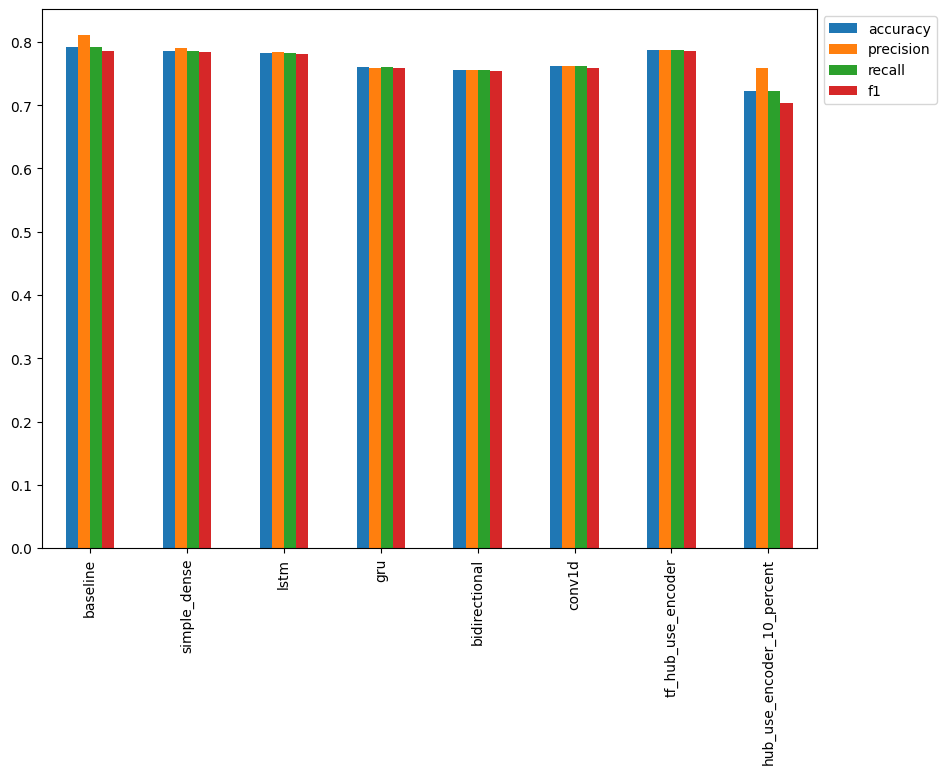

In [95]:
# Plot and compare all of the model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

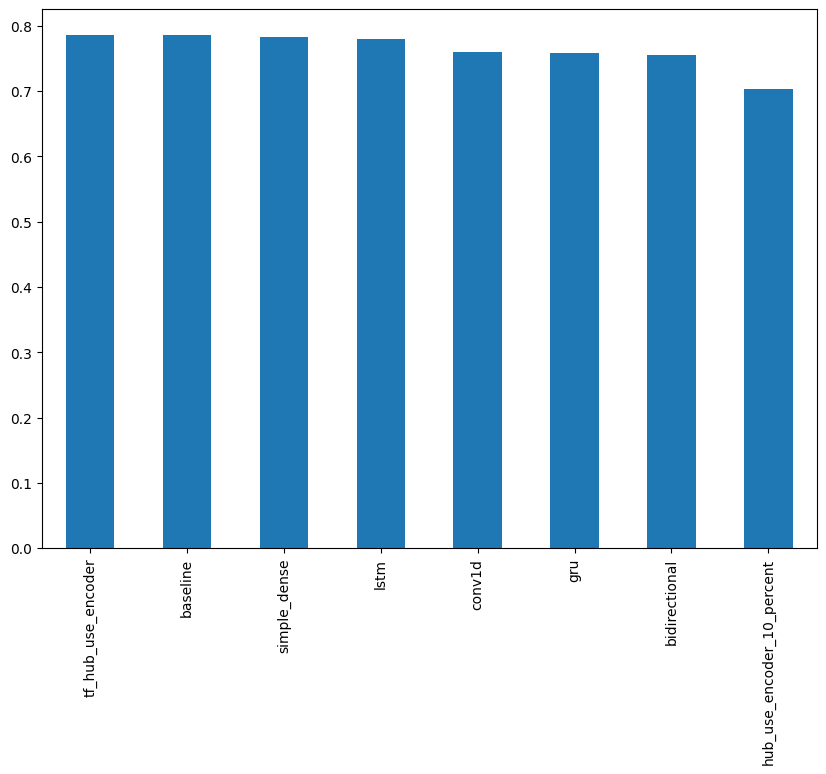

In [99]:
# Sort model results by f1-sore
all_model_results.sort_values('f1',ascending=False)['f1'].plot(kind='bar', figsize=(10, 7))

**Saving our model**

In [100]:
model_6.save('model_6.h5')

C:\Users\jagam\anaconda3\envs\tensorflow\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [101]:
# Load the moel we have saved
loaded_model_6 = tf.keras.models.load_model('model_6.h5',
                                           custom_objects={'KerasLayer': hub.KerasLayer})

In [102]:
loaded_model_6.evaluate(val_sentences,val_labels)

24/24 [==============================] - 2s 22ms/step - loss: 0.4956 - accuracy: 0.7874


[0.49563470482826233, 0.787401556968689]

In [104]:
# create DataFrame with validation sentences and bets performing model predictions
model_6_pretrained = tf.keras.models.load_model('E:/08_model_6_USE_feature_extractor')

In [105]:
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 6ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [106]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_pretrained_preds[:10]

24/24 [==============================] - 1s 6ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [109]:
val_df = pd.DataFrame({
    'text': val_sentences,
    'target': val_labels,
    'pred': model_6_pretrained_preds,
    'pred_prob': tf.squeeze(model_6_pretrained_pred_probs)
})

In [111]:
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [112]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob',ascending=False)

In [113]:
most_wrong

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
...,...,...,...,...
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949


In [115]:
# Check the false positive (model predicted 1 when actual value is 0)
for row in most_wrong[:10].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"target: {target}, Pred: {pred}, Prob: {pred_prob}")
    print(f"Text:\n{text}\n")
    print('-----\n')

target: 0, Pred: 1.0, Prob: 0.9101957082748413
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

-----

target: 0, Pred: 1.0, Prob: 0.8769820928573608
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

-----

target: 0, Pred: 1.0, Prob: 0.8354544639587402
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

-----

target: 0, Pred: 1.0, Prob: 0.8272132277488708
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

-----

target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

-----

target: 0, Pred: 1.0, Prob: 0.8108397722244263
Text:
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y 

In [125]:
# Check the false negative (model predicted 0 when actual value is 1)
for row in most_wrong[-10:].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"target: {target}, Pred: {pred}, Prob: {pred_prob}")
    print(f"Text:\n{text}\n")
    print('-----\n')

target: 1, Pred: 0.0, Prob: 0.06730347871780396
Text:
@DavidVonderhaar At least you were sincere ??

-----

target: 1, Pred: 0.0, Prob: 0.055075839161872864
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

-----

target: 1, Pred: 0.0, Prob: 0.05460338667035103
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

-----

target: 1, Pred: 0.0, Prob: 0.054596997797489166
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

-----

target: 1, Pred: 0.0, Prob: 0.04963729530572891
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

-----

target: 1, Pred: 0.0, Prob: 0.04391847923398018
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

-----

target: 1, Pred: 0.0, Pr

## Making predictions on Test dataset

In [123]:
# Making predictions on test dataset and visualizing them
import random
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06730347871780396
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0, Prob: 0.055075839161872864
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.05460338667035103
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.054596997797489166
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.04963729530572891
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.04391847923398018
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0, Prob: 0.04208683222532

## The Speed/score tradeoff

In [142]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
    '''
    Time how long a model takes to make predictions on samples.
    '''
    start_time = time.perf_counter() # get start time
    model.predict(samples)
    end_time = time.perf_counter()
    total_time = end_time - start_time # calculate how long it takes to make predictions
    time_per_pred = total_time/len(val_sentences)
    return total_time, time_per_pred

In [144]:
# calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                          samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 7ms/step


(0.32005549999303184, 0.0004200203411982045)

In [146]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.023504999990109354, 3.0846456679933536e-05)

In [148]:
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                              y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 78.74015748031496,
 'precision': 0.7878968015414602,
 'recall': 0.7874015748031497,
 'f1': 0.7862340407224944}

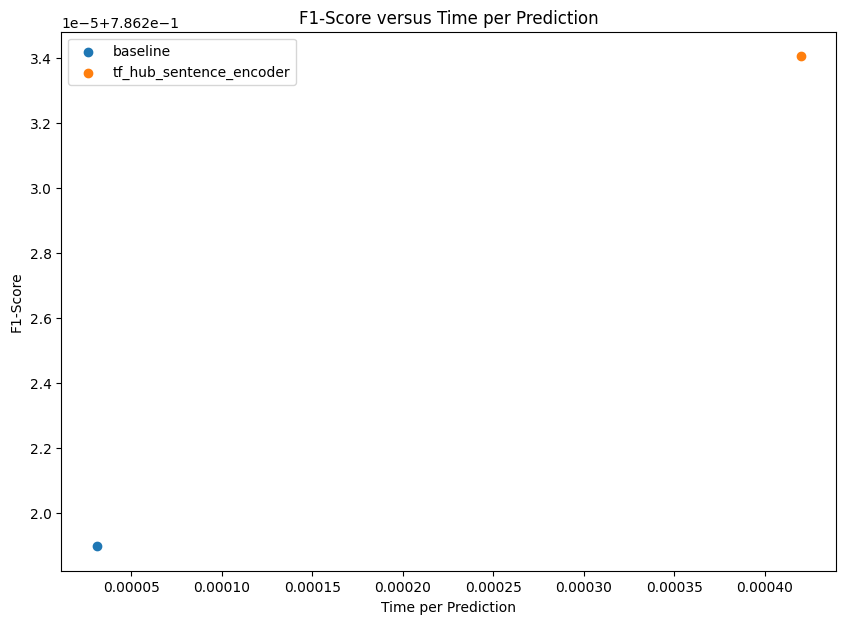

In [154]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results['f1'], label='baseline')
plt.scatter(model_6_time_per_pred, model_6_pretrained_results['f1'], label='tf_hub_sentence_encoder')
plt.legend()
plt.title('F1-Score versus Time per Prediction')
plt.xlabel('Time per Prediction')
plt.ylabel('F1-Score')
plt.show()
